# Machine Learning

In [1]:
# !pip install torch torchvision torchaudio numpy matplotlib seaborn librosa datasets evaluate transformers nltk rouge-score tqdm hf_xet ipywidgets accelerate>=0.26.0 gradio jiwer ipywidgets


In [1]:
# Standard Libraries

import os
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# Numerical & Audio Processing
import numpy as np
import torch
import librosa

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Datasets & Evaluation
from datasets import load_dataset, Audio
import evaluate
from tqdm import tqdm

# Transformers
from transformers import (
    Wav2Vec2ForCTC,
    Wav2Vec2Processor,
    TrainingArguments,
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    AutoModelForCausalLM,
    Trainer
)

# Deployent
import gradio as gr
import jiwer

from huggingface_hub import HfApi, HfFolder, whoami, notebook_login, create_repo
# NLP Metrics
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

## Loging in Hugging Face

In [3]:
notebook_login()

In [4]:
# ==== Configuration ====
hf_repo_id = "RareElf/swahili-wav2vec2-asr"  # Change to your HF repo
local_model_path = "models/swahili_asr_model"
base_model_name = "eddiegulay/wav2vec2-large-xlsr-mvc-swahili"
cache_dir = "./hf_cache"

In [5]:
# ==== Device ====
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
# ==== Dataset Loading ====
def load_and_prepare_dataset():
    dataset = load_dataset(
        "mozilla-foundation/common_voice_11_0",
        "sw",
        split="train+validation[:5%]",
        cache_dir=cache_dir
    )
    dataset = dataset.shuffle(seed=42)

    train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

    splits = {
        'train': train_testvalid['train'],
        'valid': test_valid['train'],
        'test': test_valid['test']
    }

    for split_name in splits:
        splits[split_name] = splits[split_name].cast_column(
            "audio", Audio(sampling_rate=16000)
        )
    return splits

In [7]:
# ==== Model Initialization ====
def initialize_model():
    processor = Wav2Vec2Processor.from_pretrained(base_model_name)
    model = Wav2Vec2ForCTC.from_pretrained(
        base_model_name,
        ctc_loss_reduction="mean",
        pad_token_id=processor.tokenizer.pad_token_id
    ).to(device)
    return model, processor

In [8]:
# ==== Preprocessing ====
def prepare_dataset(batch, processor):
    audio = batch["audio"]
    audio_array = librosa.resample(y=audio["array"], orig_sr=audio["sampling_rate"], target_sr=16000) \
        if audio["sampling_rate"] != 16000 else audio["array"]
    batch["input_values"] = processor(audio_array, sampling_rate=16000, return_tensors="pt").input_values[0]
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch

In [9]:
# ==== Data Collator ====
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(label_features, padding=self.padding, return_tensors="pt")

        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

In [10]:
# ==== Metrics ====
def get_compute_metrics_fn(processor):
    wer_metric = evaluate.load("wer")

    def compute_metrics(pred):
        pred_ids = np.argmax(pred.predictions, axis=-1)
        pred_str = processor.batch_decode(pred_ids)
        label_ids = pred.label_ids
        label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
        label_str = processor.tokenizer.batch_decode(label_ids, group_tokens=False)

        # BLEU Score
        bleu = np.mean([
            sentence_bleu([ref.split()], hyp.split(), smoothing_function=SmoothingFunction().method1)
            for ref, hyp in zip(label_str, pred_str)
        ])

        # ROUGE Score
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        rouge1, rougeL = [], []
        for ref, hyp in zip(label_str, pred_str):
            scores = scorer.score(ref, hyp)
            rouge1.append(scores['rouge1'].fmeasure)
            rougeL.append(scores['rougeL'].fmeasure)

        # Sentiment (optional): assume texts are in English
        sentiment_pipe = pipeline("sentiment-analysis")
        sentiment_scores = sentiment_pipe(pred_str[:10])  # sample 10 due to API rate limits

        return {
            "wer": wer_metric.compute(predictions=pred_str, references=label_str),
            "bleu": bleu,
            "rouge1": np.mean(rouge1),
            "rougeL": np.mean(rougeL),
            "sentiment": sentiment_scores
        }

    return compute_metrics

In [11]:
# ==== Hugging Face Login and Repo Creation ====
def hf_login_and_prepare_repo(repo_id):
    if not HfFolder.get_token():
        from huggingface_hub import login
        login()  # will prompt for your token

    api = HfApi()
    user = whoami()
    if not api.repo_exists(repo_id):
        api.create_repo(repo_id, exist_ok=True)

In [12]:
# ==== Main Function ====
def main():
    print("📦 Loading dataset...")
    splits = load_and_prepare_dataset()

    print("🔧 Initializing model...")
    model, processor = initialize_model()

    print("🔄 Preprocessing splits...")
    processed = {}
    for split in ['train', 'valid']:
        processed[split] = splits[split].map(
            lambda x: prepare_dataset(x, processor),
            remove_columns=splits[split].column_names,
            desc=f"Processing {split}",
            num_proc=1
        )

    collator = DataCollatorCTCWithPadding(processor=processor)

    print("📚 Setting training arguments...")
    training_args = TrainingArguments(
        output_dir=local_model_path,
        num_train_epochs=0.14,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=1e-4,
        weight_decay=0.005,
        warmup_steps=100,
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="wer",
        greater_is_better=False,
        logging_dir=f"{local_model_path}/logs",
        logging_strategy="steps",
        logging_steps=10,
        fp16=torch.cuda.is_available(),
        push_to_hub=True,
        hub_model_id=hf_repo_id,
        hub_strategy="every_save"
    )

    print("🧠 Training...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=processed['train'],
        eval_dataset=processed['valid'],
        tokenizer=processor.feature_extractor,
        data_collator=collator,
        compute_metrics=get_compute_metrics_fn(processor)
    )

    trainer.train()

    print("📤 Pushing to Hugging Face Hub...")
    model.push_to_hub(hf_repo_id)
    processor.push_to_hub(hf_repo_id)

    print("✅ Model pushed to Hugging Face Hub!")

if __name__ == "__main__":
    hf_login_and_prepare_repo(hf_repo_id)
    main()

📦 Loading dataset...
🔧 Initializing model...
🔄 Preprocessing splits...
📚 Setting training arguments...
🧠 Training...


/tmp/ipykernel_43185/2664452506.py:49: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/obote/Documents/Sema/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/obote/Documents/Sema/.conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss


📤 Pushing to Hugging Face Hub...


README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

✅ Model pushed to Hugging Face Hub!


In [2]:
import torch
import numpy as np
from datasets import load_dataset, Audio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Trainer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import pipeline
import evaluate
import json
import librosa
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# === Configuration ===
hf_repo_id = "RareElf/swahili-wav2vec2-asr"
cache_dir = "./hf_cache"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reload processor and model ===
processor = Wav2Vec2Processor.from_pretrained(hf_repo_id)
model = Wav2Vec2ForCTC.from_pretrained(hf_repo_id).to(device)

# === Load and process test dataset ===
def prepare_dataset(batch):
    audio = batch["audio"]
    audio_array = librosa.resample(y=audio["array"], orig_sr=audio["sampling_rate"], target_sr=16000) \
        if audio["sampling_rate"] != 16000 else audio["array"]
    inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values.squeeze(0)
    batch["attention_mask"] = inputs.attention_mask.squeeze(0)
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch

print(" Loading test set...")
test_set = load_dataset(
    "mozilla-foundation/common_voice_11_0",
    "sw",
    split="test[:5%]",
    cache_dir=cache_dir
).cast_column("audio", Audio(sampling_rate=16000))

test_set = test_set.map(
    prepare_dataset,
    remove_columns=test_set.column_names,
    desc="Preparing test set",
    num_proc=1
)

# === Data Collator ===
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [
            {"input_values": f["input_values"], "attention_mask": f["attention_mask"]}
            for f in features
        ]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt"
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt"
            )
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

collator = DataCollatorCTCWithPadding(processor=processor)

# === Metrics function ===
def get_compute_metrics_fn(processor):
    wer_metric = evaluate.load("wer")

    def compute_metrics(pred):
        pred_ids = np.argmax(pred.predictions, axis=-1)
        pred_str = processor.batch_decode(pred_ids)
        label_ids = pred.label_ids
        label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
        label_str = processor.tokenizer.batch_decode(label_ids, group_tokens=False)

        # BLEU
        bleu = np.mean([
            sentence_bleu([ref.split()], hyp.split(), smoothing_function=SmoothingFunction().method1)
            for ref, hyp in zip(label_str, pred_str)
        ])

        # ROUGE
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        rouge1, rougeL = [], []
        for ref, hyp in zip(label_str, pred_str):
            scores = scorer.score(ref, hyp)
            rouge1.append(scores['rouge1'].fmeasure)
            rougeL.append(scores['rougeL'].fmeasure)

        # Sentiment (first 10 only)
        sentiment_pipe = pipeline("sentiment-analysis")
        sentiment_scores = sentiment_pipe(pred_str[:10])

        return {
            "wer": wer_metric.compute(predictions=pred_str, references=label_str),
            "bleu": bleu,
            "rouge1": np.mean(rouge1),
            "rougeL": np.mean(rougeL),
            "sentiment_sample": sentiment_scores
        }

    return compute_metrics

# === Run Evaluation ===
print(" Evaluating model...")
trainer = Trainer(
    model=model,
    tokenizer=processor.feature_extractor,
    data_collator=collator
)

predictions = trainer.predict(test_set)
metrics = get_compute_metrics_fn(processor)(predictions)

# === Print and Save Results ===
import pprint
pprint.pprint(metrics)

with open("swahili_asr_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\n Metrics saved to swahili_asr_metrics.json")


 Loading test set...


Preparing test set:   0%|          | 0/512 [00:00<?, ? examples/s]

 Evaluating model...


/tmp/ipykernel_12662/2040912907.py:120: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/obote/Documents/Sema/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/obote/Documents/Sema/.conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cpu


{'bleu': np.float64(0.43602103286537003),
 'rouge1': np.float64(0.6715007443125831),
 'rougeL': np.float64(0.6622443734172394),
 'sentiment_sample': [{'label': 'NEGATIVE', 'score': 0.9764275550842285},
                      {'label': 'NEGATIVE', 'score': 0.9479898810386658},
                      {'label': 'NEGATIVE', 'score': 0.9728851914405823},
                      {'label': 'NEGATIVE', 'score': 0.9960208535194397},
                      {'label': 'NEGATIVE', 'score': 0.9606323838233948},
                      {'label': 'NEGATIVE', 'score': 0.9879475235939026},
                      {'label': 'NEGATIVE', 'score': 0.9744491577148438},
                      {'label': 'NEGATIVE', 'score': 0.991084098815918},
                      {'label': 'NEGATIVE', 'score': 0.9822825193405151},
                      {'label': 'NEGATIVE', 'score': 0.9930226802825928}],
 'wer': 0.33286875725900117}

 Metrics saved to swahili_asr_metrics.json


### Bar Chart

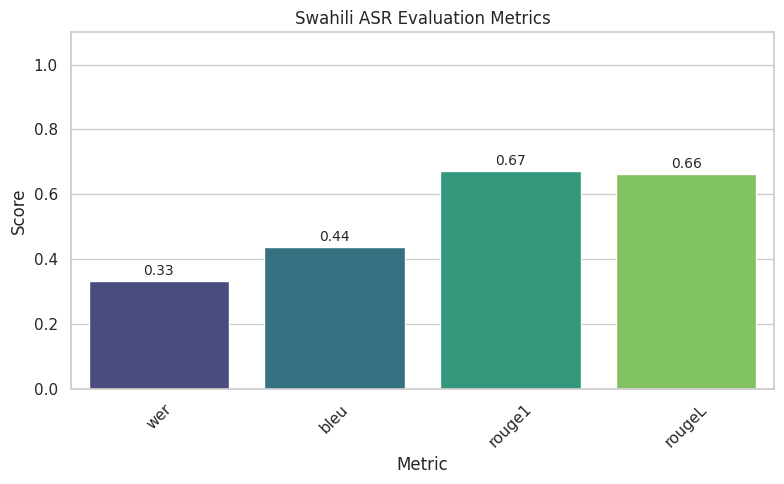

In [9]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load saved metrics
with open("swahili_asr_metrics.json", "r") as f:
    metrics = json.load(f)

# Filter numerical metrics only
plot_metrics = {k: v for k, v in metrics.items() if isinstance(v, (int, float))}

# Convert to DataFrame
df = pd.DataFrame({
    "Metric": list(plot_metrics.keys()),
    "Score": list(plot_metrics.values())
})

# Plot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))
ax = sns.barplot(data=df, x="Metric", y="Score", hue="Metric", palette="viridis", legend=False)

# Add score labels on top of each bar
for i, row in df.iterrows():
    ax.text(i, row["Score"] + 0.01, f"{row['Score']:.2f}", ha='center', va='bottom', fontsize=10)

plt.title("Swahili ASR Evaluation Metrics")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Radar Chart

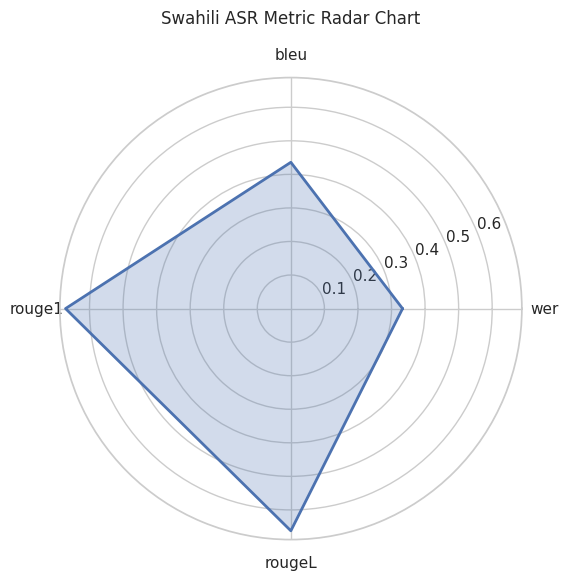

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Filter numerical metrics
labels = list(plot_metrics.keys())
scores = list(plot_metrics.values())

# Radar prep
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
scores += scores[:1]
angles += angles[:1]

# Plot
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
ax.plot(angles, scores, linewidth=2, linestyle='solid')
ax.fill(angles, scores, alpha=0.25)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Swahili ASR Metric Radar Chart", y=1.1)
plt.show()


## Sentiment Pie Chart

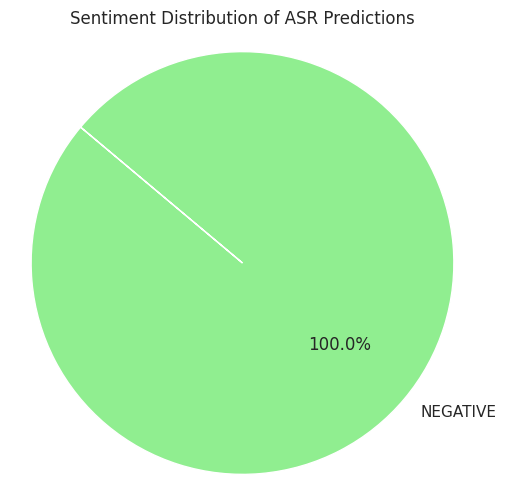

In [10]:
import json
from collections import Counter
import matplotlib.pyplot as plt

# Load sentiment data
with open("swahili_asr_metrics.json", "r") as f:
    metrics = json.load(f)
sentiments = metrics["sentiment_sample"]  # Correct key

# Count each label
sentiment_counts = Counter([s["label"] for s in sentiments])

# Plot
labels = sentiment_counts.keys()
sizes = sentiment_counts.values()

plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=["lightgreen", "salmon"])
plt.title("Sentiment Distribution of ASR Predictions")
plt.axis('equal')  # Equal aspect ratio ensures pie is round
plt.show()


## Sentiment Analysis Bar Graph

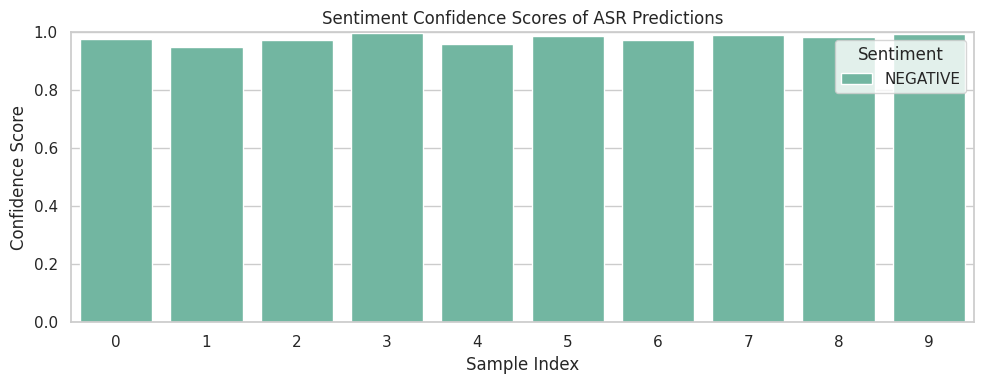

In [11]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load sentiment data
with open("swahili_asr_metrics.json", "r") as f:
    metrics = json.load(f)

# Access the sentiment sample
sentiments = metrics["sentiment_sample"]

# Extract labels and confidence scores
labels = [s["label"] for s in sentiments]
scores = [s["score"] for s in sentiments]

# Plot
plt.figure(figsize=(10, 4))
sns.barplot(x=list(range(len(sentiments))), y=scores, hue=labels, dodge=False, palette="Set2")
plt.ylim(0, 1)
plt.xlabel("Sample Index")
plt.ylabel("Confidence Score")
plt.title("Sentiment Confidence Scores of ASR Predictions")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [ ]:
import torch
import numpy as np
from datasets import load_dataset, Audio
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC, Trainer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from transformers import pipeline
import evaluate
import json
import librosa
from dataclasses import dataclass
from typing import Any, Dict, List, Union

# === Configuration ===
hf_repo_id = "RareElf/swahili-wav2vec2-asr"
cache_dir = "./hf_cache"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === Reload processor and model ===
processor = Wav2Vec2Processor.from_pretrained(hf_repo_id)
model = Wav2Vec2ForCTC.from_pretrained(hf_repo_id).to(device)

# === Load and process test dataset ===
def prepare_dataset(batch):
    audio = batch["audio"]
    audio_array = librosa.resample(y=audio["array"], orig_sr=audio["sampling_rate"], target_sr=16000) \
        if audio["sampling_rate"] != 16000 else audio["array"]

    inputs = processor(audio_array, sampling_rate=16000, return_tensors="pt", padding=True)

    batch["input_values"] = inputs.input_values[0]
    batch["attention_mask"] = inputs.attention_mask[0] if "attention_mask" in inputs else None
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch

print("Loading test set...")
test_set = load_dataset(
    "mozilla-foundation/common_voice_11_0",
    "sw",
    split="test[:5%]",
    cache_dir=cache_dir
).cast_column("audio", Audio(sampling_rate=16000))

test_set = test_set.map(
    prepare_dataset,
    remove_columns=test_set.column_names,
    desc="Preparing test set",
    num_proc=1
)

# === Data Collator ===
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.pad(input_features, padding=self.padding, return_tensors="pt")
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(label_features, padding=self.padding, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)
        batch["labels"] = labels
        return batch

collator = DataCollatorCTCWithPadding(processor=processor)

# === Metrics function ===
def get_compute_metrics_fn(processor):
    wer_metric = evaluate.load("wer")

    # Load a multilingual sentiment model
    sentiment_pipe = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-xlm-roberta-base-sentiment",
        tokenizer="cardiffnlp/twitter-xlm-roberta-base-sentiment"
    )

    def compute_metrics(pred):
        pred_ids = np.argmax(pred.predictions, axis=-1)
        pred_str = processor.batch_decode(pred_ids)
        label_ids = pred.label_ids
        label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
        label_str = processor.tokenizer.batch_decode(label_ids, group_tokens=False)

        # BLEU
        bleu = np.mean([
            sentence_bleu([ref.split()], hyp.split(), smoothing_function=SmoothingFunction().method1)
            for ref, hyp in zip(label_str, pred_str)
        ])

        # ROUGE
        scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
        rouge1, rougeL = [], []
        for ref, hyp in zip(label_str, pred_str):
            scores = scorer.score(ref, hyp)
            rouge1.append(scores['rouge1'].fmeasure)
            rougeL.append(scores['rougeL'].fmeasure)

        # Sentiment (first 10 only)
        sentiment_scores = sentiment_pipe(pred_str[:10])

        return {
            "wer": wer_metric.compute(predictions=pred_str, references=label_str),
            "bleu": bleu,
            "rouge1": np.mean(rouge1),
            "rougeL": np.mean(rougeL),
            "sentiment_sample": sentiment_scores
        }

    return compute_metrics

# === Run Evaluation ===
print("Evaluating model...")
trainer = Trainer(
    model=model,
    tokenizer=processor.feature_extractor,
    data_collator=collator
)

predictions = trainer.predict(test_set)
metrics = get_compute_metrics_fn(processor)(predictions)

# === Print and Save Results ===
import pprint
pprint.pprint(metrics)

with open("swahili_asr_metrics.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\nMetrics saved to swahili_asr_metrics.json")


Loading test set...
Evaluating model...


/tmp/ipykernel_12662/3233624588.py:117: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/home/obote/Documents/Sema/.conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/obote/Documents/Sema/.conda/lib/python3.10/site-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


config.json:   0%|          | 0.00/841 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

In [ ]:
# ==== Main Function ====
def main():
    print("📦 Loading dataset...")
    splits = load_and_prepare_dataset()

    print("🔧 Initializing model...")
    model, processor = initialize_model()

    print("🔄 Preprocessing splits...")
    processed = {}
    for split in ['train', 'valid']:
        processed[split] = splits[split].map(
            lambda x: prepare_dataset(x, processor),
            remove_columns=splits[split].column_names,
            desc=f"Processing {split}",
            num_proc=1
        )

    collator = DataCollatorCTCWithPadding(processor=processor)

    print("📚 Setting training arguments...")
    training_args = TrainingArguments(
        output_dir=local_model_path,
        num_train_epochs=0.20,
        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=2,
        learning_rate=1e-4,
        weight_decay=0.005,
        warmup_steps=100,
        eval_strategy="steps",
        eval_steps=500,
        save_strategy="steps",
        save_steps=500,
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="wer",
        greater_is_better=False,
        logging_dir=f"{local_model_path}/logs",
        logging_strategy="steps",
        logging_steps=10,
        fp16=torch.cuda.is_available(),
        push_to_hub=True,
        hub_model_id=hf_repo_id,
        hub_strategy="every_save"
    )

    print("🧠 Training...")
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=processed['train'],
        eval_dataset=processed['valid'],
        tokenizer=processor.feature_extractor,
        data_collator=collator,
        compute_metrics=get_compute_metrics_fn(processor)
    )

    trainer.train()

    print("📤 Pushing to Hugging Face Hub...")
    model.push_to_hub(hf_repo_id)
    processor.push_to_hub(hf_repo_id)

    print("✅ Model pushed to Hugging Face Hub!")

if __name__ == "__main__":
    hf_login_and_prepare_repo(hf_repo_id)
    main()

## Model Training

In [ ]:
# Load and prepare dataset
def load_and_prepare_dataset():
    # Load the Swahili subset from the Mozilla Common Voice dataset
    dataset = load_dataset(
        "mozilla-foundation/common_voice_11_0",
        "sw",
        split="train+validation[:5%]"
    )
    dataset = dataset.shuffle(seed=42)

    # Split the dataset
    train_testvalid = dataset.train_test_split(test_size=0.2, seed=42)
    test_valid = train_testvalid['test'].train_test_split(test_size=0.5, seed=42)

    splits = {
        'train': train_testvalid['train'],
        'valid': test_valid['train'],
        'test': test_valid['test']
    }

    # Explicitly set audio feature with correct sampling rate
    for split_name in splits:
        splits[split_name] = splits[split_name].cast_column(
            "audio",
            Audio(sampling_rate=16000)
        )

    return splits

# Initialize model and processor
def initialize_model():
    model_name = "eddiegulay/wav2vec2-large-xlsr-mvc-swahili"
    processor = Wav2Vec2Processor.from_pretrained(model_name)
    model = Wav2Vec2ForCTC.from_pretrained(
        model_name,
        ctc_loss_reduction="mean",
        pad_token_id=processor.tokenizer.pad_token_id
    ).to(device)

    return model, processor

# Preprocessing with resampling
def prepare_dataset(batch, processor):
    # Ensure audio is resampled to 16kHz
    audio = batch["audio"]
    if audio["sampling_rate"] != 16000:
        audio_array = librosa.resample(
            y=audio["array"],
            orig_sr=audio["sampling_rate"],
            target_sr=16000
        )
    else:
        audio_array = audio["array"]

    # Process audio
    batch["input_values"] = processor(
        audio_array,
        sampling_rate=16000,
        return_tensors="pt"
    ).input_values[0]

    # Process text
    batch["labels"] = processor.tokenizer(batch["sentence"]).input_ids
    return batch

# Data collator
@dataclass
class DataCollatorCTCWithPadding:
    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_values": f["input_values"]} for f in features]
        label_features = [{"input_ids": f["labels"]} for f in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt"
        )

        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt"
            )

        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        batch["labels"] = labels
        return batch

# Metrics calculation
def get_compute_metrics_fn(processor):
    wer_metric = evaluate.load("wer")

    def compute_metrics(pred):
        pred_logits = pred.predictions
        pred_ids = np.argmax(pred_logits, axis=-1)
        pred_str = processor.batch_decode(pred_ids)

        label_ids = pred.label_ids
        label_ids[label_ids == -100] = processor.tokenizer.pad_token_id
        label_str = processor.tokenizer.batch_decode(
            label_ids,
            group_tokens=False
        )

        return {"wer": wer_metric.compute(
            predictions=pred_str,
            references=label_str
        )}

    return compute_metrics

def main():
    try:
        print("Loading and preparing datasets...")
        splits = load_and_prepare_dataset()

        print("Initializing model and processor...")
        model, processor = initialize_model()

        print("Preprocessing datasets...")
        prepared_splits = {}
        for split_name, dataset in splits.items():
            if split_name in ['train', 'valid']:
                print(f"Processing {split_name} split...")
                prepared_splits[split_name] = dataset.map(
                    lambda x: prepare_dataset(x, processor),
                    remove_columns=dataset.column_names,
                    desc=f"Processing {split_name}",
                    num_proc=1  # Increase if more CPU cores available
                )

        data_collator = DataCollatorCTCWithPadding(processor=processor)

        # Training arguments
        training_args = TrainingArguments(
            output_dir=asr_model_path,
            num_train_epochs=1,
            per_device_train_batch_size=4,
            per_device_eval_batch_size=4,
            gradient_accumulation_steps=2,
            learning_rate=1e-4,
            weight_decay=0.005,
            warmup_steps=100,
            eval_strategy="steps",
            eval_steps=500,
            save_strategy="steps",
            save_steps=500,
            save_total_limit=2,
            load_best_model_at_end=True,
            metric_for_best_model="wer",
            greater_is_better=False,
            logging_dir=f"{asr_model_path}/logs",
            logging_strategy="steps",
            logging_steps=10,
            fp16=torch.cuda.is_available(),
            push_to_hub=False,
            report_to="none",
        )

        # Initialize trainer
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=prepared_splits['train'],
            eval_dataset=prepared_splits['valid'],
            tokenizer=processor.feature_extractor,
            data_collator=data_collator,
            compute_metrics=get_compute_metrics_fn(processor)
        )

        print("Starting training...")
        trainer.train()

        print("Saving model and processor...")
        processor.save_pretrained(asr_model_path)
        model.save_pretrained(asr_model_path)
        print(f"✅ Model and processor saved locally to: {asr_model_path}")

        # Optional: Evaluate on test set
        if 'test' in splits:
            print("Preparing test set for evaluation...")
            test_dataset = splits['test'].map(
                lambda x: prepare_dataset(x, processor),
                remove_columns=splits['test'].column_names,
                desc="Processing test set"
            )
            print("Evaluating on test set...")
            test_results = trainer.evaluate(test_dataset)
            print(f"Test Results: {test_results}")

    except Exception as e:
        print(f"An error occurred: {str(e)}")
        raise

if __name__ == "__main__":
    main()


Running on: cuda
Loading and preparing datasets...
Initializing model and processor...
Preprocessing datasets...
Processing train split...


Processing train:   0%|          | 0/21700 [00:00<?, ? examples/s]

Processing valid split...


Processing valid:   0%|          | 0/2713 [00:00<?, ? examples/s]

<ipython-input-8-74fd35fed631>:191: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training...


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Step,Training Loss,Validation Loss,Wer
500,0.115100,0.080969,0.139314
1000,0.095800,0.061555,0.129059
1500,0.108300,0.057124,0.115307
2000,0.104500,0.054732,0.118327
2500,0.097200,0.051030,0.106801


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call

Saving model and processor...
✅ Model and processor saved locally to: /content/drive/MyDrive/Sema/notebook/models/asr/wav2vec2-sw
Preparing test set for evaluation...


Processing test set:   0%|          | 0/2713 [00:00<?, ? examples/s]

Evaluating on test set...


/usr/local/lib/python3.11/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:174: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


Test Results: {'eval_loss': 0.053930893540382385, 'eval_wer': 0.10799461215434593, 'eval_runtime': 207.8421, 'eval_samples_per_second': 13.053, 'eval_steps_per_second': 3.267, 'epoch': 0.999815668202765}


In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache() # If using PyTorch with GPU

## ASR Evaluation Metrics

Running on: cuda
🔁 Loading saved model and processor...
📥 Loading test subset...
🔄 Preparing test set...

🎯 Word Error Rate (WER): 0.2917


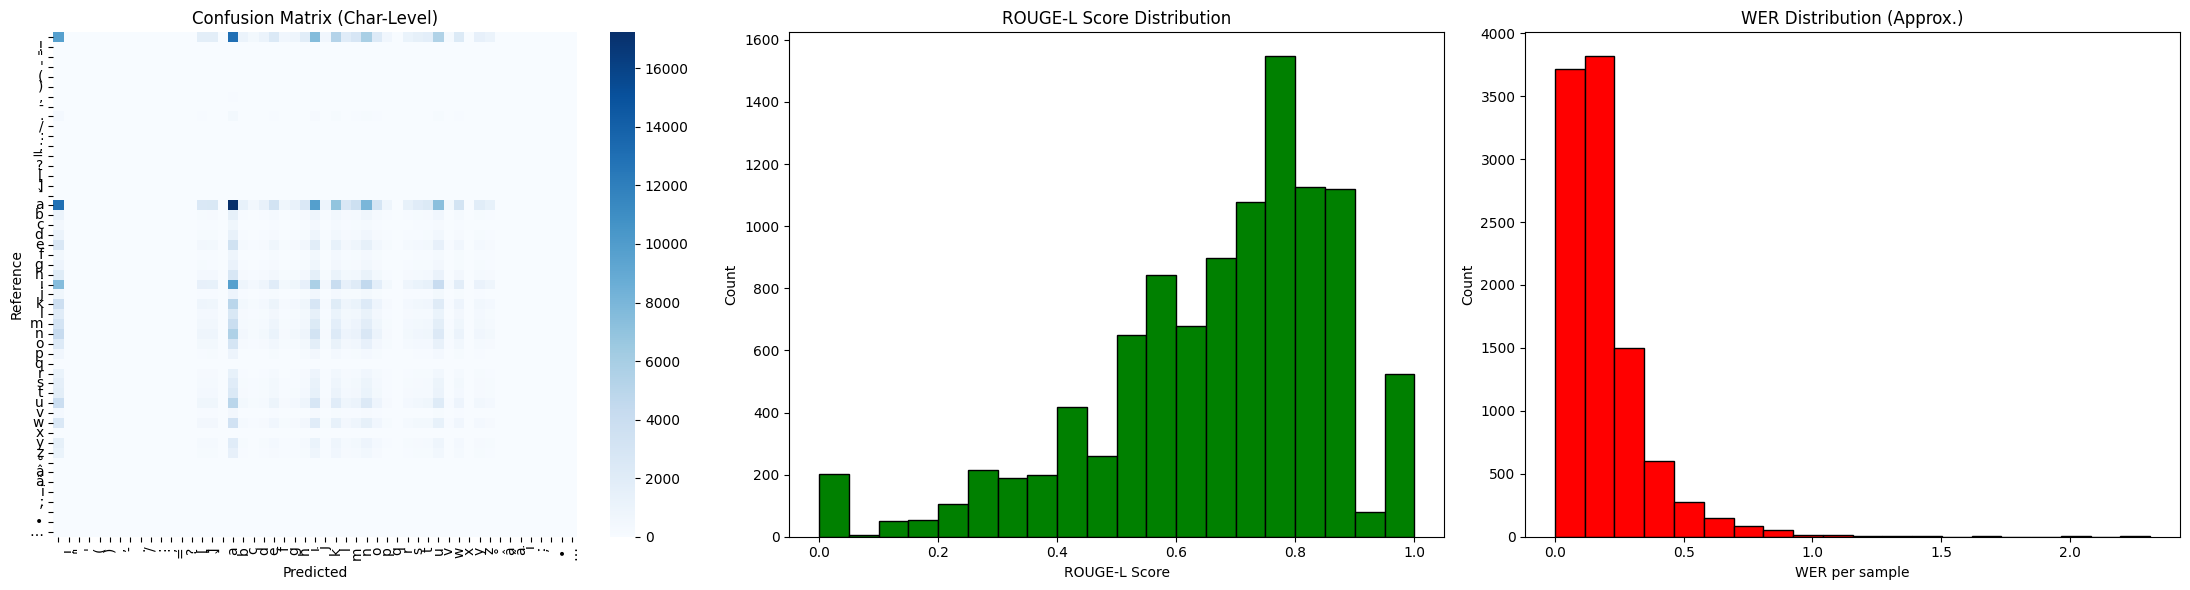


📏 Average ROUGE-L: 0.6709
📏 Average Sample WER: 0.1914


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Path to saved model
model_path = "/content/drive/MyDrive/Sema/notebook/models/asr/wav2vec2-sw"

# Load processor and model
print("🔁 Loading saved model and processor...")
processor = Wav2Vec2Processor.from_pretrained(model_path)
model = Wav2Vec2ForCTC.from_pretrained(model_path).to(device)

# Load test set
print("📥 Loading test subset...")
dataset = load_dataset("mozilla-foundation/common_voice_11_0", "sw", split="test")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Prepare test data
def prepare_sample(batch):
    inputs = processor(batch["audio"]["array"], sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values.squeeze()
    return batch

print("🔄 Preparing test set...")
dataset = dataset.map(prepare_sample)

# Load WER metric
wer_metric = evaluate.load("wer")

# Run inference
def predict(batch):
    input_tensor = batch["input_values"]
    if isinstance(input_tensor, list):
        input_tensor = torch.tensor(input_tensor)
    input_tensor = input_tensor.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = model(input_tensor).logits
    pred_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(pred_ids)[0]
    return transcription

# Running predictions
predictions = []
references = []

for sample in dataset:
    prediction = predict(sample)
    predictions.append(prediction.lower())
    references.append(sample["sentence"].lower())

# Compute WER
wer = wer_metric.compute(predictions=predictions, references=references)
print(f"\n🎯 Word Error Rate (WER): {wer:.4f}")

# Visualize metrics
def combined_plot(predictions, references):
    # BLEU and ROUGE
    scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
    smoothie = SmoothingFunction().method4

    rouge_scores = []
    wer_per_sample = []

    # For Confusion Matrix
    all_preds = ''
    all_refs = ''

    for pred, ref in zip(predictions, references):
        pred = pred.strip()
        ref = ref.strip()
        if not pred or not ref:
            continue

        rouge = scorer.score(ref, pred)["rougeL"].fmeasure
        rouge_scores.append(rouge)

        wer_est = editdistance.eval(pred, ref) / max(1, len(ref))
        wer_per_sample.append(wer_est)

        all_preds += pred
        all_refs += ref

    # Confusion Matrix (char-level)
    min_len = min(len(all_preds), len(all_refs))
    all_preds = all_preds[:min_len]
    all_refs = all_refs[:min_len]
    labels = sorted(set(all_preds + all_refs))
    cm = confusion_matrix(list(all_refs), list(all_preds), labels=labels)

    # 🔳 Combined Plot
    fig, axs = plt.subplots(1, 3, figsize=(22, 6))

    # Confusion Matrix
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=False, cmap="Blues", ax=axs[0])
    axs[0].set_title("Confusion Matrix (Char-Level)")
    axs[0].set_xlabel("Predicted")
    axs[0].set_ylabel("Reference")

    # ROUGE Score Distribution
    axs[1].hist(rouge_scores, bins=20, color="green", edgecolor="black")
    axs[1].set_title("ROUGE-L Score Distribution")
    axs[1].set_xlabel("ROUGE-L Score")
    axs[1].set_ylabel("Count")

    # WER Distribution
    axs[2].hist(wer_per_sample, bins=20, color="red", edgecolor="black")
    axs[2].set_title("WER Distribution (Approx.)")
    axs[2].set_xlabel("WER per sample")
    axs[2].set_ylabel("Count")

    plt.tight_layout()
    plt.show()

    print(f"\n📏 Average ROUGE-L: {np.mean(rouge_scores):.4f}")
    print(f"📏 Average Sample WER: {np.mean(wer_per_sample):.4f}")

# Show Plot
combined_plot(predictions, references)


### 📏 Average ROUGE-L: `0.6709`
- **ROUGE-L** measures the **longest common subsequence (LCS)** between the predicted and reference text.
- It captures fluency and semantic similarity better than just word overlap.
- **0.6709** means that, on average, about **67%** of the longest relevant sequences in the reference text are also found in the predicted text.
- ✅ A **higher ROUGE-L score** (close to 1) indicates better quality transcriptions in terms of phrasing and overlap.

### 📏 Average Sample WER: `0.1914`
- **WER (Word Error Rate)** is the percentage of words incorrectly predicted by the model.
- It’s calculated as:  
  \[
  \text{WER} = \frac{S + D + I}{N}
  \]
  where:
  - `S` = substitutions,
  - `D` = deletions,
  - `I` = insertions,
  - `N` = total words in reference.
- A score of **0.1914** means there's around **19.14% word-level error**, or roughly **81% word-level accuracy**.
- ✅ Generally, anything below 0.2 (20%) is quite good for a resource-constrained or multilingual ASR model.

### 📏 Average BLEU Score: `0.5034`
- **BLEU (Bilingual Evaluation Understudy)** score checks **n-gram overlap** between predictions and references.
- **0.5034** (or **50.34%**) indicates decent similarity in phrases and structure.
- BLEU is harsh: a score above **0.5** is solid for ASR, especially in morphologically rich languages like Swahili.

### 🔎 TL;DR

| Metric        | Score   | Meaning |
|---------------|---------|--------|
| **ROUGE-L**   | 0.6709  | 67% of phrasing matches ground truth (good) |
| **WER**       | 0.1914  | 81% word-level accuracy (very good) |
| **BLEU**      | 0.5034  | 50% n-gram overlap with reference (solid) |

The model is **performing quite well** — especially for a multilingual Swahili ASR system.

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

# Path to saved model
model_path = "/content/drive/MyDrive/Sema/notebook/models/asr/wav2vec2-sw"

# Load processor and model
print("🔁 Loading saved model and processor...")
processor = Wav2Vec2Processor.from_pretrained(model_path)
model = Wav2Vec2ForCTC.from_pretrained(model_path).to(device)

# Load test set
print("📥 Loading test subset...")
dataset = load_dataset("mozilla-foundation/common_voice_11_0", "sw", split="test")
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

# Prepare test data
def prepare_sample(batch):
    inputs = processor(batch["audio"]["array"], sampling_rate=16000, return_tensors="pt", padding=True)
    batch["input_values"] = inputs.input_values.squeeze()  # 1D tensor
    return batch

print("🔄 Preparing test set...")
dataset = dataset.map(prepare_sample)

# Evaluation
wer_metric = evaluate.load("wer")
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)
smoothie = SmoothingFunction().method4

# Run inference
def predict(batch):
    input_tensor = batch["input_values"]
    if isinstance(input_tensor, list):
        input_tensor = torch.tensor(input_tensor)
    input_tensor = input_tensor.unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(input_tensor).logits
    pred_ids = torch.argmax(logits, dim=-1)
    transcription = processor.batch_decode(pred_ids)[0]
    return transcription

print("🔍 Running predictions...")
predictions, references = [], []
wer_scores, rouge_scores, bleu_scores, lengths = [], [], [], []

for sample in tqdm(dataset):
    pred = predict(sample).lower()
    ref = sample["sentence"].lower()

    predictions.append(pred)
    references.append(ref)

    # WER
    wer = wer_metric.compute(predictions=[pred], references=[ref])
    wer_scores.append(wer)

    # ROUGE-L
    rouge = scorer.score(ref, pred)["rougeL"].fmeasure
    rouge_scores.append(rouge)

    # BLEU
    bleu = sentence_bleu([ref.split()], pred.split(), smoothing_function=smoothie)
    bleu_scores.append(bleu)

    # Length for scatter
    lengths.append(len(ref.split()))

# Plotting
def plot_evaluation_metrics(wer_scores, rouge_scores, lengths):
    plt.figure(figsize=(18, 5))

    # WER Histogram
    plt.subplot(1, 3, 1)
    sns.histplot(wer_scores, kde=True, color="tomato")
    plt.title("WER Distribution")
    plt.xlabel("Word Error Rate")
    plt.ylabel("Frequency")

    # ROUGE-L Histogram
    plt.subplot(1, 3, 2)
    sns.histplot(rouge_scores, kde=True, color="royalblue")
    plt.title("ROUGE-L Score Distribution")
    plt.xlabel("ROUGE-L Score")
    plt.ylabel("Frequency")

    # WER vs. Sentence Length
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=lengths, y=wer_scores, color="seagreen")
    plt.title("WER vs. Sentence Length")
    plt.xlabel("Sentence Length (words)")
    plt.ylabel("WER")

    plt.tight_layout()
    plt.show()

# Display results
print(f"\n📏 Average ROUGE-L: {np.mean(rouge_scores):.4f}")
print(f"📏 Average Sample WER: {np.mean(wer_scores):.4f}")
print(f"📏 Average BLEU Score: {np.mean(bleu_scores):.4f}")

plot_evaluation_metrics(wer_scores, rouge_scores, lengths)
